# LBM 1D Code Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
from IPython.display import HTML
import sympy as sp

## Problem Definiton

Define diffusivity $D$, domain length $L$ and maximum time $t_{max}$

In [2]:
D = 0.07
L = 1.0
t_max = 0.8

In [3]:
def ic(x):
    return np.exp(-((x - 1 / 2) / 0.1) ** 2)

In [4]:
def source(x,t):
    return 0

## Numerical parameters
Define number of lattice nodes $nx$, number of time steps $nt$ and the weighting factor $\theta$. The refinement factor $rf<1$ allows to increase resolution according to the diffusive scaling.

In [5]:
nx = 32
nt = 800
rf = 1

## Preprocessing
 - Compute the discretization to be used in the analysis: $nx\leftarrow nx/rf$ and $nt\leftarrow nt/rf^2$
 - Determine lattice spacing $\Delta x = L/nx$ and time step size $\Delta t = t_{max}/nt$
 - Setup an array of lattice node locations (assuming $\Delta x/2$ padding at the left and right side of the $(0,L)$ domain
 - Calculate the relaxation rate $\omega$

In [6]:
nx = int(nx/rf);
nt = int(nt/rf**2);
dx = L/nx;
dt = t_max/nt;
omega = 1/(D*dt/(dx**2)+0.5);

## Equilibrium
Define the local equilibrium $f^{eq}(u)$

In [7]:
def feq(u):
    return np.array([
        (1 / 2) * u,
        (1 / 2) * u
    ])

## Definition of a single LBM time step
 - Compute zeroth-order moment $u^{num} = \sum_i f_i$
 - Perform collision
 - Perform streaming
 - Apply periodic boundary conditions

In [8]:
def timestep(f, omega, phi_dt):
    unum = np.sum(f, axis=0) + phi_dt/2
    fpost = omega*feq(unum) + (1-omega)*f
    fpost[0,:] = fpost[0,:] + (1-omega/2)*phi_dt/2
    fpost[1,:] = fpost[1,:] + (1-omega/2)*phi_dt/2
    
    f[0,1:] = fpost[0,:-1]
    f[1,:-1] = fpost[1,1:]

    f[0,0] = fpost[0,-1]
    f[1,-1] = fpost[1,0]
    
    return f, unum

## Time step loop

Define and execute lattice Boltzmann method with given initial condition for $nt$ time steps. The lattice nodes are located at a $\Delta x/2$ offset from the domain boundary, i.e. $x_{domain} = \{1/2\Delta x, 3/2\Delta x, \dots, L-1/2\Delta x\}$

In [9]:
def lbm(L, dx, dt, nx, nt, omega, D, output_interval=10):
    """
    Run LBM simulation but store outputs only at the first, last, and every output_interval step.

    Parameters
    ----------
    L, dx, dt, nx, nt, omega, D : float, int
        Standard LBM simulation parameters.
    output_interval : int
        Save output every this many iterations (default = 10).

    Returns
    -------
    x_domain : ndarray, shape (nx,)
        Spatial grid points.
    u_out : ndarray, shape (n_outputs, nx)
        Stored velocity (or field) at selected time steps.
    u_ex : ndarray, shape (n_outputs, nx)
        Analytical/reference field at selected time steps.
    output_times : ndarray, shape (n_outputs,)
        Iteration numbers corresponding to saved outputs.
    """
    
    # Create x-domain
    x_domain = np.arange(dx / 2, L, dx)
    
    # Determine which timesteps to store
    if nt > 2:
        output_times = np.unique(
            np.concatenate(([0],
                            np.arange(output_interval, nt, output_interval),
                            [nt - 1]))
        )
    else:
        output_times = np.arange(nt)
    
    # Preallocate for only saved outputs
    n_outputs = len(output_times)
    u_out = np.zeros((n_outputs, nx))
    
    # Initialize distribution function
    f = feq(ic(x_domain))
    
    # Simulation loop
    out_idx = 0
    for it in range(nt):
        phi = source(x_domain, it * dt)
        f, u = timestep(f, omega, phi * dt)
        
        # Save only at selected intervals
        if it in output_times:
            u_out[out_idx, :] = u
            out_idx += 1
    
    return x_domain, u_out, output_times

In [10]:
x_domain, u_out, out_times = lbm(L,dx,dt,nx,nt,omega,D, 100)

## Visualization

Create animation of $u^{num}$

In [11]:
def animate_lbm_outputs(u_out, x_domain, output_times, u_out2=None, labels=("u₁", "u₂")):
    """
    Animate LBM output arrays (u_out, optionally u_out2) over x_domain,
    using provided output_times for the frame labels.

    Parameters
    ----------
    u_out : ndarray, shape (n_outputs, nx)
        Primary dataset to animate (rows = saved time steps).
    x_domain : ndarray
        Spatial grid points (same for all frames).
    output_times : ndarray
        The iteration numbers (or times) corresponding to each saved frame.
    u_out2 : ndarray, optional
        Second dataset to plot alongside u_out (same shape).
    labels : tuple(str)
        Legend labels for the plotted lines.
    interval_ms : int
        Animation speed in milliseconds between frames (default 100).

    Returns
    -------
    HTML animation object (for Jupyter display)
    """
    n_outputs, nx = u_out.shape

    # --- Set up figure ---
    fig, ax = plt.subplots(figsize=(6, 4))
    line1, = ax.plot([], [], lw=2, label=labels[0])
    line2 = None
    if u_out2 is not None:
        line2, = ax.plot([], [], lw=2, label=labels[1], linestyle="--")

    # Auto scale y-axis to fit both datasets if provided
    u_min = np.min(u_out)
    u_max = np.max(u_out)
    if u_out2 is not None:
        u_min = min(u_min, np.min(u_out2))
        u_max = max(u_max, np.max(u_out2))

    ax.set_xlim(x_domain[0], x_domain[-1])
    ax.set_ylim(1.1*u_min, 1.1*u_max)
    ax.set_xlabel("x")
    ax.set_ylabel("u")
    ax.grid(True)
    if u_out2 is not None:
        ax.legend()

    # --- Initialization ---
    def init():
        line1.set_data([], [])
        if line2:
            line2.set_data([], [])
        return (line1, line2) if line2 else (line1,)

    # --- Frame update ---
    def update(frame_idx):
        line1.set_data(x_domain, u_out[frame_idx, :])
        if line2 is not None:
            line2.set_data(x_domain, u_out2[frame_idx, :])
        ax.set_title(f"timestep = {output_times[frame_idx]}")
        return (line1, line2) if line2 else (line1,)

    # --- Animation ---
    ani = FuncAnimation(fig, update, frames=n_outputs, init_func=init,
                        blit=True, interval=100, repeat=False)
    plt.close(fig)  # prevent duplicate static plot

    return HTML(ani.to_jshtml())

In [12]:
animate_lbm_outputs(u_out, x_domain, out_times)

# Convergence study

## Manufactured Solutions

For a given target solution $u(x,t)$ generate the corresponding source term $\varphi$ by introducing $u$ into the target equation: $b = \partial_t u - D \partial_x^2 u$.

In [13]:
x, t = sp.symbols('x t')
u_sym = sp.sin(2 * sp.pi * (x - t / 3))
u_exact = sp.lambdify((x, t), u_sym, 'numpy')

In [14]:
b_sym = sp.diff(u_sym,t) - D*sp.diff(u_sym,x,2)
source = sp.lambdify((x, t), b_sym, 'numpy')

In [15]:
ic = lambda x: u_exact(x, 0)

In [16]:
x_domain, u_out, out_times = lbm(L,dx,dt,nx,nt,omega,D, 100)

In [17]:
def evaluate_u_exact(x_domain, out_times, dt):
    n_out = len(out_times)
    nx = len(x_domain)
    
    u_ex = np.zeros((n_out, nx))
    out_idx = 0
    for it in out_times:
        u_ex[out_idx,:] = u_exact(x_domain, it*dt)
        out_idx += 1

    return u_ex

In [18]:
u_ex = evaluate_u_exact(x_domain, out_times, dt)
animate_lbm_outputs(u_out, x_domain, out_times, u_ex, labels=("$u^{num}$", "$u^{exact}$"))

In [19]:
def l2_norm(u_error, dx):
    return np.sqrt(dx) * np.linalg.norm(u_error)
def linf_norm(u_error):
    return np.max(np.abs(u_error))

In [20]:
l2 = l2_norm(u_out[-1,:] - u_ex[-1,:], dx) / l2_norm(u_ex[-1,:], dx)
linf = linf_norm(u_out[-1,:] - u_ex[-1,:]) / l2_norm(u_ex[-1,:], dx)
print(f"l2 = {l2}")
print(f"linf = {linf}")

l2 = 0.007373275563078317
linf = 0.010427385060161522


In [21]:
nx_base = 32
nt_base = 800
rf_list = [1, 1/2, 1/3, 1/4]

In [22]:
def convergence_study(L, t_max, nx_base, nt_base, omega, D, rf_list):
    n_run = len(rf_list)
    l2 = np.zeros(n_run)
    linf = np.zeros(n_run)
    dx_list = np.zeros(n_run)
    
    for i, rf in enumerate(rf_list):
        nx = int(nx_base/rf)
        nt = int(nt_base/rf**2)

        dx = L/nx
        dt = t_max/nt
        x_domain, u_out, out_times = lbm(L, dx, dt, nx, nt, omega, D, output_interval=nt)
        u_ex = evaluate_u_exact(x_domain, out_times, dt)

        l2[i] = l2_norm(u_out[-1,:] - u_ex[-1,:], dx) / l2_norm(u_ex[-1,:], dx)
        linf[i] = linf_norm(u_out[-1,:] - u_ex[-1,:]) / l2_norm(u_ex[-1,:], dx)
        dx_list[i] = dx

    return dx_list, l2, linf

In [23]:
dx_list, l2, linf = convergence_study(L, t_max, nx_base, nt_base, omega, D, rf_list)

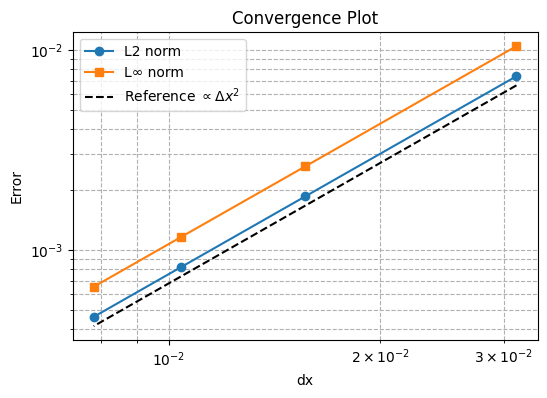

In [24]:
plt.figure(figsize=(6, 4))

plt.loglog(dx_list, l2, 'o-', label='L2 norm')
plt.loglog(dx_list, linf, 's-', label='L∞ norm')

C = l2[0] / dx_list[0]**2
ref_line = 0.9*C * dx_list**2
plt.loglog(dx_list, ref_line, 'k--', label=r'Reference $\propto \Delta x^2$')

plt.xlabel('dx')
plt.ylabel('Error')
plt.title('Convergence Plot')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()